Origianl author: ichen

Last Modified: Fr Oct 28 2022 09:05:21 AM UTC+09:00

Modified By: Siheon Park (sihoney97@kaist.ac.kr)

In [1]:
import sys
from pathlib import Path
sys.path.extend([f"{Path.home()/'Exact_Diagonalization'}"])


In [2]:

import Exact_diagonalization as ed
from scipy.sparse.linalg import expm_multiply
import numpy as np
import pickle
import json
from matplotlib import pyplot as plt

def dyn(Total_time,time_steps,ham,init_state):
    
    state_t=np.zeros((2**L,time_steps+1),dtype=complex)
    
    state_t[:,0]=init_state
    
    for i in range(time_steps):
        
        state_t[:,i+1]=expm_multiply(-1j*dt*ham,state_t[:,i])
        
    return state_t

def z_exp_val(sp,i,state_t,time_steps):
    sz=sp.spin_z(i)
    exp_z=[]
    for i in range(time_steps):
        
        exp_z.append(np.dot(np.conjugate(state_t[:,i]),sz.dot(state_t[:,i])))
        
    return np.real(exp_z)

def y_exp_val(sp,i,state_t,time_steps):
    sy=sp.spin_y(i)
    exp_y=[]
    for i in range(time_steps):
        
        exp_y.append(np.dot(np.conjugate(state_t[:,i]),sy.dot(state_t[:,i])))
        
    return np.real(exp_y)

def x_exp_val(sp,i,state_t,time_steps):
    sx=sp.spin_x(i)
    exp_x=[]
    for i in range(time_steps):
        
        exp_x.append(np.dot(np.conjugate(state_t[:,i]),sx.dot(state_t[:,i])))
        
    return np.real(exp_x)

def data_saving(z_exp_t,y_exp_t,x_exp_t,tv_lst,encoding_num): 
    
    Num=len(z_exp_t)
    
    data_Num=Num-encoding_num
    
    num_t=data_Num*tv_lst[0]//(tv_lst[0]+tv_lst[1])
    
    num_v=data_Num-num_t
    
    z_train_output_t=z_exp_t[-data_Num:][:num_t]
    x_train_output_t=x_exp_t[-data_Num:][:num_t]
    y_train_output_t=y_exp_t[-data_Num:][:num_t]
    
    z_val_output_t=z_exp_t[-data_Num:][num_t:]
    x_val_output_t=x_exp_t[-data_Num:][num_t:]
    y_val_output_t=y_exp_t[-data_Num:][num_t:]
    
    training_data_set={}
    training_data_set['input']={}
    training_data_set['output']={}
    
    val_data_set={}
    val_data_set['input']={}
    val_data_set['output']={}
    
    for  pauli in ['X','Y','Z']:
        training_data_set['input'][pauli]=[]
        val_data_set['input'][pauli]=[]
        
        training_data_set['output'][pauli]=[]
        val_data_set['output'][pauli]=[]
    
    for i in range(num_t):
         
        training_data_set['input']['X'].append(list(x_exp_t[i:i+encoding_num]))
        training_data_set['input']['Y'].append(list(y_exp_t[i:i+encoding_num]))
        training_data_set['input']['Z'].append(list(z_exp_t[i:i+encoding_num]))
        
        training_data_set['output']['X'].append(x_train_output_t[i])
        training_data_set['output']['Y'].append(y_train_output_t[i])
        training_data_set['output']['Z'].append(z_train_output_t[i])
        
    for i in range(num_v):
        
        val_data_set['input']['X'].append(list(x_exp_t[i+num_t:i+encoding_num+num_t]))
        val_data_set['input']['Y'].append(list(y_exp_t[i+num_t:i+encoding_num+num_t]))
        val_data_set['input']['Z'].append(list(z_exp_t[i+num_t:i+encoding_num+num_t]))
        
        val_data_set['output']['X'].append(x_val_output_t[i])
        val_data_set['output']['Y'].append(y_val_output_t[i])
        val_data_set['output']['Z'].append(z_val_output_t[i])
    
    # create json object from dictionary
    with open('train_data.json', 'w') as fp:
        json.dump(training_data_set, fp)
        
    with open('val_data.json', 'w') as fp:
        json.dump(val_data_set, fp)
        
def reduced_1_spin_density_matrix(state_vector,pos):
    num_cb=len(state_vector)
    sys_size=int(np.log(num_cb)/np.log(2))
    dic={}
    dic['1']=[]
    dic['0']=[]
    for i in range(num_cb):
        bit_string=format(i,'0{}b'.format(sys_size))[::-1]
        if bit_string[pos]=='1':
            dic['1']+=[state_vector[i]]
        elif bit_string[pos]=='0':
            dic['0']+=[state_vector[i]]
            
    density_matrix=np.zeros((2,2),dtype=complex)
    density_matrix[0,0]=np.conjugate(dic['0']).dot(dic['0'])
    density_matrix[1,0]=np.conjugate(dic['1']).dot(dic['0'])
    density_matrix[0,1]=np.conjugate(dic['0']).dot(dic['1'])
    density_matrix[1,1]=np.conjugate(dic['1']).dot(dic['1'])
    
    return density_matrix

def data_density_matrix_saving_encoding_1(Density_data_t,tv_ratio):
    tot_data_num=len(Density_data_t)
    num_train_data=int(tot_data_num*tv_ratio)
    num_val_data=tot_data_num-num_train_data
    train_data={}
    train_data['input']=[]
    train_data['output']=[]

    val_data={}
    val_data['input']=[]
    val_data['output']=[]
    
    for i in range(num_train_data-1):
        train_data['input'].append(Density_data_t[i])
        train_data['output'].append(Density_data_t[i+1])
    path_dir='opflow_train_data_set'
    with open(path_dir, 'wb') as handle:
        pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    

    for i in range(num_val_data):
        val_data['input'].append(Density_data_t[num_train_data+i-1])
        val_data['output'].append(Density_data_t[num_train_data+i])
    path_dir='opflow_val_data_set'
    with open(path_dir, 'wb') as handle:
        pickle.dump(val_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def densit_matrix(X_val,Y_val,Z_val):
    X=np.zeros((2,2),dtype=int)
    Y=np.zeros((2,2),dtype=complex)
    Z=np.zeros((2,2),dtype=int)
    X[0,1]=X[1,0]=1
    Y[0,1]=-1j
    Y[1,0]=1j
    Z[0,0]=1
    Z[1,1]=-1
    
    DM=[]
    num=len(X_val)
    for i in range(num):
        DM.append((np.eye(2)+X_val[i]*X+Y_val[i]*Y+Z_val[i]*Z)/2)
    return DM

In [3]:
L=10
sp=ed.spin_half_system(L)    
# create system hamiltonian

i_site=L-1 # where system locate
hx=1 
ham_S=hx*sp.spin_x(i_site)

# Create environment ham w/ open boundary condition (Heisenberg model)
ham_E=0
hz=1
Jzz=1
Jxy=1
for i in range(L):
    if i != i_site: 
        ham_E+=hz*sp.spin_z(i)
        
    if i != i_site and i+1 !=i_site and i != L-1:
        
        ham_E+=Jzz*sp.spin_z(i).dot(sp.spin_z(i+1))           
        ham_E+=Jxy*sp.spin_x(i).dot(sp.spin_x(i+1))
        ham_E+=Jxy*sp.spin_y(i).dot(sp.spin_y(i+1))
        
# Creating the interaction Hamiltonian
ham_SE=0
Jzz=0.5

#ham_SE+=Jzz*sp.spin_z(i_site).dot(sp.spin_z(i_site+1))
ham_SE+=Jzz*sp.spin_z(i_site-1).dot(sp.spin_z(i_site))

# Total Hamtonian  
tot_h=ham_SE+ham_E+ham_S   
Total_time=10

time_steps=100
dt=Total_time/time_steps
state_t=np.zeros((2**L,time_steps+1),dtype=complex)

init_state=np.zeros(2**L) ##np.ones(2**L, dtype=int)/np.sqrt(2**L)
#init_state=np.ones(2**L, dtype=int)/np.sqrt(2**L)
f=1  # |0000000001> |>

init_state[f]=1


state_t=dyn(Total_time,time_steps,tot_h,init_state)

y_exp=y_exp_val(sp,i_site,state_t,time_steps+1)
z_exp=z_exp_val(sp,i_site,state_t,time_steps+1)
x_exp=x_exp_val(sp,i_site,state_t,time_steps+1)

DM=densit_matrix(x_exp,y_exp,z_exp)

#density_matrix=[]
#for i in range(time_steps):
#    density_matrix.append(reduced_1_spin_density_matrix(state_t[:,i],i_site)) 
    
data_density_matrix_saving_encoding_1(DM,0.8)

path_dir='opflow_train_data_set'

with open(path_dir, 'rb') as handle:
        
      train_data = pickle.load(handle)

path_dir='opflow_val_data_set'

with open(path_dir, 'rb') as handle:
        
      val_data = pickle.load(handle)

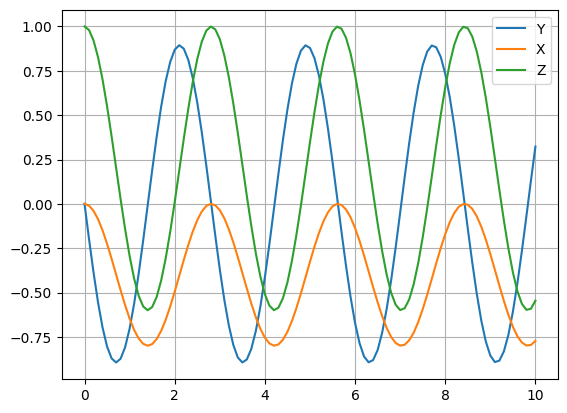

In [4]:
Time=np.linspace(0,Total_time,time_steps+1)
plt.plot(Time,y_exp,label='Y')
plt.plot(Time,x_exp,label='X')
plt.plot(Time,z_exp,label='Z')
plt.legend()
plt.grid()

In [5]:
from dqnn.opflow import OpflowDQNN, DensityMatrix
from tqdm import trange
from torch.utils.tensorboard import SummaryWriter

In [6]:
def expand_rdm(*args:np.ndarray)->np.ndarray:
    """expand density matrices

    Returns:
        np.ndarray: expanded density matrix
    """
    rdms = list(map(DensityMatrix, args))
    rdm = rdms[0]
    for other in rdms[1:]:
        rdm = rdm.expand(other)
    return np.array(rdm)

def expand_data(data:np.ndarray, n:int)->np.ndarray:
    """expand data

    Args:
        data (np.ndarray): data
        n (int): expand size

    Returns:
        np.ndarray: expanded data
    """
    ret = []
    for i in range(len(data)-n+1):
        ret.append(expand_rdm(*data[i:i+n]))
    return np.array(ret)

In [7]:
trainingData = np.array(train_data['input'])
targetStates = np.array(train_data['output'])

val_Data = np.array(val_data['input'])
val_targetStates = np.array(val_data['output'])

In [8]:
expanded_trainingData = expand_data(trainingData, 3)
expanded_targetStates = targetStates[2:]

expanded_val_Data = expand_data(val_Data, 3)
expanded_val_targetStates = val_targetStates[2:]

In [9]:
model = OpflowDQNN([3, 2, 1], epsilon=0.03)
unitaries = model.makeRandomUnitaries(seed=0)

train_loss_list = []
val_loss_list = []
writer = SummaryWriter(log_dir='./runs/DQNN')
for s in trange(1000):
    loss = model.step(unitaries, expanded_trainingData, expanded_targetStates)
    writer.add_scalar('Loss', loss, s)
    train_loss_list.append(loss)
    feedforward_results=model.feedforward(unitaries, expanded_val_Data)
    val_loss=model.cost(feedforward_results[-1], expanded_val_targetStates)
    val_loss_list.append(val_loss)

100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]


Final fidelity: 0.9993549322262727 / 0.9993164405273507


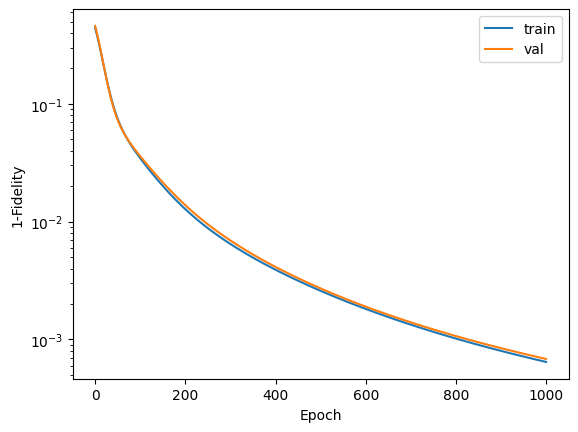

In [14]:
import matplotlib.pyplot as plt
plt.plot(1-np.array(train_loss_list),label='train')
plt.plot(1-np.array(val_loss_list),label='val')
plt.xlabel('Epoch')
plt.ylabel('1-Fidelity')
plt.legend()
plt.yscale('log')
print('Final fidelity:', train_loss_list[-1], "/", val_loss_list[-1])

In [15]:
X=np.zeros((2,2),dtype=int)
Y=np.zeros((2,2),dtype=complex)
Z=np.zeros((2,2),dtype=int)
X[0,1]=X[1,0]=1
Y[0,1]=-1j
Y[1,0]=1j
Z[0,0]=1
Z[1,1]=-1
tot_data=np.concatenate((trainingData, val_Data))
expanded_tot_data=expand_data(tot_data,3)
feedforward_results=model.feedforward(unitaries, expanded_tot_data)
X_predict=[x_exp[0]]
Y_predict=[y_exp[0]]
Z_predict=[z_exp[0]]
num=len(feedforward_results[-1])
for i in range(num):
    X_predict.append(np.real(np.trace(feedforward_results[-1][i].dot(X))))
    Y_predict.append(np.real(np.trace(feedforward_results[-1][i].dot(Y))))
    Z_predict.append(np.real(np.trace(feedforward_results[-1][i].dot(Z))))

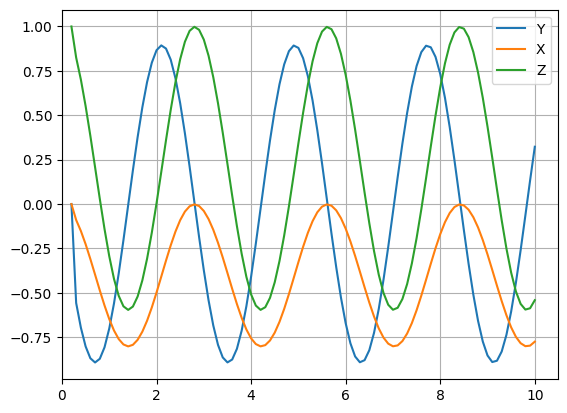

In [16]:
Time=np.linspace(2*Total_time/time_steps,Total_time,time_steps-1)
plt.plot(Time,Y_predict,label='Y')
plt.plot(Time,X_predict,label='X')
plt.plot(Time,Z_predict,label='Z')
plt.xlim([0, None])
plt.legend()
plt.grid()

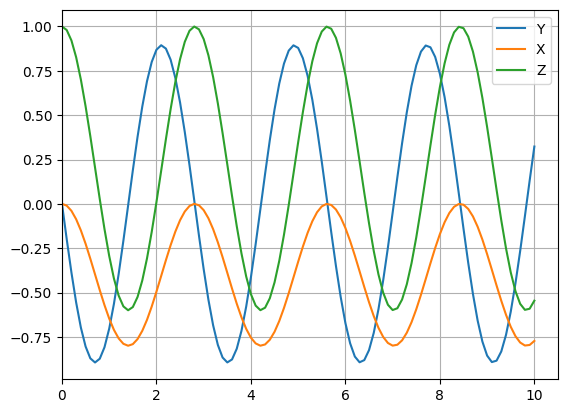

In [17]:
Time=np.linspace(0,Total_time,time_steps+1)
plt.plot(Time,y_exp,label='Y')
plt.plot(Time,x_exp,label='X')
plt.plot(Time,z_exp,label='Z')
plt.xlim([0, None])
plt.legend()
plt.grid()